<a href="https://colab.research.google.com/github/atul6876/Diabetic_Retinopathy_Detection/blob/main/Diabetic_Retinopathy_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Diabetic Retinopathy Detection - Approach 1**

*   We have 3662 images as our training dataset with labels for each stage of DR along with healthy fundus images. 
*   We can either design and train a model to detect each and every stage or we can build a model to just classify the difference between healthy and DR fundus images.
* Keeping in mind the limitations of Google Colab in terms of GPU capabilitites, our first approach would be to build a model to just detect whether a fundus image is that of a healthy eye or of a person with any stage of Diabetic Retinopathy.


 

 



In [ ]:
# Change Runtime Type to GPU. The code below checks if the GPU is provisioned for this runtime
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Import the necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import sklearn

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model                                      # Model is useful to edit the layers of an existing model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

Using TensorFlow backend.


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Aptos Dataset/train.csv')
data.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
data['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

* Since our training images are all mixed in one single directory, we cannot use flow_from_directory method. Instead we use 'flow_from_dataframe' method.
* One of the requirements of the flow_from_dataframe mehtod is that the image labels be in text format as a column in the dataframe.
* The dataframe should also have the full image paths (with their format i.e. '.png', '.jpg' etc.) or full image names (example: 'imageid.png') with directory path provided as a separate argument.

In [ ]:
Binary_Diagnosis=[]
for i in data['diagnosis']:
    if i != 0:
        Binary_Diagnosis.append('Retinopathy')
    else:
        Binary_Diagnosis.append('healthy')
print(len(Binary_Diagnosis))

3662


In [ ]:
data['Binary_Diagnosis'] = Binary_Diagnosis
data.head()

,id_code,diagnosis,Binary_Diagnosis
0,000c1434d8d7,2,Retinopathy
1,001639a390f0,4,Retinopathy
2,0024cdab0c1e,1,Retinopathy
3,002c21358ce6,0,healthy
4,005b95c28852,0,healthy


In [ ]:
img_id = [(i+'.png') for i in data['id_code']]                                  # adding the image format '.png' to the image_id 
len(img_id)

3662

In [ ]:
data['img_id'] = img_id
data.head()

,id_code,diagnosis,Binary_Diagnosis,img_id
0,000c1434d8d7,2,Retinopathy,000c1434d8d7.png
1,001639a390f0,4,Retinopathy,001639a390f0.png
2,0024cdab0c1e,1,Retinopathy,0024cdab0c1e.png
3,002c21358ce6,0,healthy,002c21358ce6.png
4,005b95c28852,0,healthy,005b95c28852.png


In [ ]:
data['Binary_Diagnosis'].value_counts()

Retinopathy    1857
healthy        1805
Name: Binary_Diagnosis, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data, test_size = 0.25, stratify = data['Binary_Diagnosis'])  # use test_size = 0.20

#train_df.head()
#test_df.head()

In [ ]:
train_df['Binary_Diagnosis'].value_counts()

Retinopathy    1392
healthy        1354
Name: Binary_Diagnosis, dtype: int64

In [ ]:
test_df['Binary_Diagnosis'].value_counts()

Retinopathy    465
healthy        451
Name: Binary_Diagnosis, dtype: int64

In [ ]:
# Setting the dimensions of our images.

img_width, img_height = 224, 224

imgs_dir = '/content/drive/My Drive/Aptos Dataset/train_images/'  # make sure at the end there is a '/' after copying the folder path from your Google drive

epochs = 5 
batch_size = 16

In [ ]:
# Setting the input shape format: 3 is the color channels (RGB)

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [ ]:
# Loading the vgg16 model from keras with imagenet weights, setting the input shape for our interests 

vgg = keras.applications.vgg16.VGG16(include_top=True
                                     , weights='imagenet'
                                     #, input_tensor=None
                                     , input_shape=input_shape
                                     #, pooling=None)
vgg.summary()                                                                   # print out the model summary

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Print the total number of layers
print(len(vgg.layers))
print()
#Print out the layers in vgg model
for layer in vgg.layers: 
    print(layer)

# Freeze the training weights until the flattening layer and only train the final 2 fully-connected layers and an updated final o/p layer with only one node 
for layer in vgg.layers[:20]:
    layer.trainable=False

23



In [ ]:
 # Change the final dense layer to 1 node (sigmoid activation) for binary classification
# could do 2 nodes and determine the probabilities of each class using SoftMax, but we used Sigmoid for our simple ConvNet
x = vgg.layers[-2].output
output_layer = Dense(1, activation='sigmoid', name='predictions')(x)

In [ ]:
# Combine the output layer to the original model
vgg_binary = Model(inputs=vgg.input, outputs=output_layer)

In [ ]:
# Sanity check: Print out the model summary. The final layer should have 1 node only (using sigmoid activation)
vgg_binary.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# Compile the modified vgg model with the following hyperparameters (same as simple ConvNet)
# In future try different learning rates for the adam 'adaptive moment estimation'
vgg_binary.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Defining Image transformations: normalization (rescaling) for both training and testing images
# Defining Image transformations: Augmenting the training data with the following transformations 
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Setting up the flow of images in batches for training and validation

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=imgs_dir,
    x_col="img_id",
    y_col="Binary_Diagnosis",
    target_size=(img_width, img_height),
    class_mode="binary",
    batch_size=batch_size
   )

validation_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=imgs_dir,
    x_col="img_id",
    y_col="Binary_Diagnosis",
    target_size=(img_width, img_height),
    class_mode="binary",
    batch_size=batch_size
   )
# Printing out the class labels for both training and validation sets
print(train_generator.class_indices)
print(validation_generator.class_indices)

Found 2746 validated image filenames belonging to 2 classes.
Found 916 validated image filenames belonging to 2 classes.
{'Retinopathy': 0, 'healthy': 1}
{'Retinopathy': 0, 'healthy': 1}


In [ ]:
history = vgg_binary.fit_generator(
        train_generator,
        steps_per_epoch=2746 // batch_size,
        epochs=epochs,                           
        validation_data=validation_generator,
        validation_steps=916 // batch_size)

vgg_binary.save('/content/drive/My Drive/Aptos Dataset/Final_Model.h5')
print('Saved the model to disk.')

Epoch 1/5
170/171 [============================>.] - ETA: 9s - loss: 1.1973 - accuracy: 0.8552 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 31 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 53 could not be retrieved. It could be because a worker has died.
  UserWarning)


171/171 [==============================] - 2311s 14s/step - loss: 1.1911 - accuracy: 0.8557 - val_loss: 0.4850 - val_accuracy: 0.9068
Epoch 2/5
171/171 [==============================] - 2354s 14s/step - loss: 0.2689 - accuracy: 0.9231 - val_loss: 0.2185 - val_accuracy: 0.9100
Epoch 3/5
171/171 [==============================] - 2305s 13s/step - loss: 0.1766 - accuracy: 0.9425 - val_loss: 0.6182 - val_accuracy: 0.9278
Epoch 4/5
171/171 [==============================] - 2152s 13s/step - loss: 0.1573 - accuracy: 0.9498 - val_loss: 0.0834 - val_accuracy: 0.9444
Epoch 5/5
171/171 [==============================] - 2093s 12s/step - loss: 0.1409 - accuracy: 0.9549 - val_loss: 0.2200 - val_accuracy: 0.9500
Saved the model to disk.


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


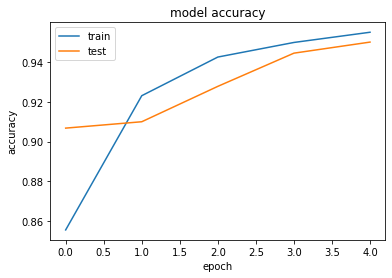

In [ ]:
# Print out the metrics recorded during training (saved in the history)
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

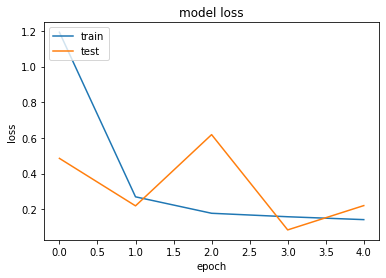

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()